In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
BASE_DIR = Path().absolute().parent.parent
sys.path.append(str(BASE_DIR))
from bayes_opt_adaptive  import BayesianOptimization
from bayes_opt_adaptive import UtilityFunction
from scipy.optimize import minimize, NonlinearConstraint, Bounds, SR1
from bayes_opt_adaptive.logger import JSONLogger
from bayes_opt_adaptive.event import Events
from bayes_opt_adaptive.util import load_logs
from cases import Case1,Case2,Case3,Case3T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

In [3]:
DIR = BASE_DIR/'scripts_res'/'Case3THyper3' 
DIR

WindowsPath('d:/OneDrive/Current/2_Codes/BO_Related/ASBO/ASBO/scripts_res/Case3THyper3')

In [4]:
sol = 'ASBO'
case_name = 'Case3T'
runs_number = 5
n_iter = 200

In [5]:
import numpy as np
from pyDOE import lhs

param_ranges = [
    [3, 4, 5],         
    [1.5, 2, 2.5],     
    [0.76, 0.78, 0.8], 
    [0.92, 0.95, 0.98] 
]
target_params = [5, 2, 0.78, 0.95]
num_samples = 40
num_params = len(param_ranges)
lhs_samples = lhs(num_params, samples=num_samples)
sampled_params = np.array([
    [param_ranges[i][int(round(lhs_value * (len(param_ranges[i]) - 1)))] for i, lhs_value in enumerate(sample)]
    for sample in lhs_samples
])
np.random.shuffle(sampled_params)
# pd.DataFrame(sampled_params).to_csv(DIR/'LHS_Case3T.csv',index=False)

In [6]:
def cleaning(df2,n_init,iter,opt):
    cumulative_max_df = pd.DataFrame()
    for index, row in df2.iterrows():
        initial_max = row[list(range(n_init))].max()
        cumulative_max_list = [initial_max]
        current_max = initial_max
        for iter_value in row[list(range(n_init,n_init+iter,1))]:
            if iter_value > current_max:
                current_max = iter_value  
            cumulative_max_list.append(current_max)  
        cumulative_max_df = pd.concat([cumulative_max_df, pd.DataFrame([cumulative_max_list])], ignore_index=True)
    cumulative_max_df.columns = [f'iter_{i+1}' for i in range(iter+1)]
    cumulative_max_df = cumulative_max_df.replace(-np.inf, np.nan)
    non_inf_counts =  cumulative_max_df.count()
    
    std = cumulative_max_df.std()
    mean = cumulative_max_df.mean(axis=0)
    regret_mean = np.log10(opt - mean)
    upper = np.log10(opt - mean + 1.96*std/np.sqrt(non_inf_counts)) #cumulative_max_df.shape[0]
    lower = np.log10(opt - mean - 1.96*std/np.sqrt(non_inf_counts)) #cumulative_max_df.shape[0]

    return cumulative_max_df,regret_mean,lower,upper,non_inf_counts

In [7]:
df = pd.read_csv(DIR/'LHS_Case3T.csv')
df_no_duplicates = df.drop_duplicates()
# df_no_duplicates

In [8]:
df_no_duplicates = df_no_duplicates.drop(15) 
# df_no_duplicates.to_csv(DIR/'LHS_Case3T_no_duplicates.csv',index=True)

In [9]:
m1_3=df_no_duplicates[df_no_duplicates['0']==3.0]
m1_4=df_no_duplicates[df_no_duplicates['0']==4.0]
m1_5=df_no_duplicates[df_no_duplicates['0']==5.0]
m2_15=df_no_duplicates[df_no_duplicates['1']==1.5]
m2_20=df_no_duplicates[df_no_duplicates['1']==2.0]
m2_25=df_no_duplicates[df_no_duplicates['1']==2.5]
P1_76=df_no_duplicates[df_no_duplicates['2']==0.76]
P1_78=df_no_duplicates[df_no_duplicates['2']==0.78]
P1_80=df_no_duplicates[df_no_duplicates['2']==0.80]
P2_92=df_no_duplicates[df_no_duplicates['3']==0.92]
P2_95=df_no_duplicates[df_no_duplicates['3']==0.95]
P2_98=df_no_duplicates[df_no_duplicates['3']==0.98]

In [10]:
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in m1_3.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_m1_3 = df
            combined2_m1_3 = df2
            temp=1
        else:
            combined_m1_3 = pd.concat([combined_m1_3, df], axis=0, ignore_index=True)
            combined2_m1_3 = pd.concat([combined2_m1_3, df2], axis=0, ignore_index=True)
print(len(combined2_m1_3.index.to_list()))
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in m1_4.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_m1_4 = df
            combined2_m1_4 = df2
            temp=1
        else:
            combined_m1_4 = pd.concat([combined_m1_4, df], axis=0, ignore_index=True)
            combined2_m1_4 = pd.concat([combined2_m1_4, df2], axis=0, ignore_index=True)
print(len(combined2_m1_4.index.to_list()))
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in m1_5.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_m1_5 = df
            combined2_m1_5 = df2
            temp=1
        else:
            combined_m1_5 = pd.concat([combined_m1_5, df], axis=0, ignore_index=True)
            combined2_m1_5 = pd.concat([combined2_m1_5, df2], axis=0, ignore_index=True)
print(len(combined2_m1_5.index.to_list()))

40
70
40


In [25]:
combined_m1_3.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-2.737477,1.484555,-1.145304,0.610063,0.991015,-0.996821,0.630503,0.630464,1.567695,0.865774
std,2.874423,2.537695,2.537871,2.565677,1.139408,2.796170,0.921096,0.876059,1.098453,0.441471
min,-6.902473,-1.221855,-5.991725,-4.024604,-1.051839,-6.007714,-0.838982,-0.835553,-0.137856,0.028968
25%,-5.068307,-0.973802,-0.933308,-0.901598,0.020534,-1.981819,-0.342131,-0.029784,0.481269,0.555297
50%,-3.494036,0.971251,-0.000206,1.006448,1.129569,-0.371815,0.627414,0.588267,2.017164,0.799136
75%,-0.266932,3.279832,0.075980,1.957540,2.005208,0.965379,1.547538,1.156339,2.541980,1.237769
max,1.994338,5.963436,1.109468,4.005395,2.108544,4.057458,1.900372,2.547360,2.972896,1.487626


In [26]:
combined_m1_4.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,-2.177358,2.424665,-1.644949,0.216371,0.892283,-1.563527,0.722685,0.319786,1.493589,0.813236
std,3.902227,2.512053,2.600293,2.685412,1.423968,2.899737,1.051433,1.061006,1.211496,0.472681
min,-10.745089,-1.972393,-5.998052,-4.997654,-1.046789,-7.090701,-0.944355,-0.999079,-0.132844,0.002227
25%,-5.198126,1.038355,-4.007552,-0.008397,-0.699628,-3.975223,-0.107414,-0.674405,0.320369,0.341711
50%,-3.481700,2.005596,-0.986814,0.106974,1.001611,-0.082250,0.900158,0.072315,1.020784,0.948682
75%,1.776992,4.976877,0.614326,1.853327,2.038465,1.022937,1.789476,1.135435,2.750951,1.124277
max,3.818609,7.955346,1.228972,4.001786,4.025360,2.115621,1.958794,2.967622,2.994782,1.494303


In [27]:
combined_m1_5.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-5.686793,2.705761,-0.505814,-0.289329,2.782027,-2.188768,0.724227,0.287433,0.871480,0.785317
std,5.163528,3.321055,3.752032,3.120614,3.409763,3.627639,0.860843,1.080849,0.821062,0.497178
min,-17.913743,-2.005967,-6.038439,-6.955465,-2.995969,-7.158840,-0.940989,-0.999755,-0.124989,0.013619
25%,-8.610279,1.061986,-2.032631,-3.484783,1.270474,-5.039051,0.305837,-0.893287,0.008721,0.305166
50%,-5.059471,2.555945,-0.000622,0.142175,2.996107,-3.975142,0.679888,0.558242,0.999988,0.816890
75%,-0.820743,4.025804,0.043203,2.129992,3.696125,1.701391,1.477861,1.002650,1.037083,1.132334
max,2.508383,8.996420,6.988867,3.033236,11.043189,3.058669,1.942071,2.588788,2.810342,1.474087


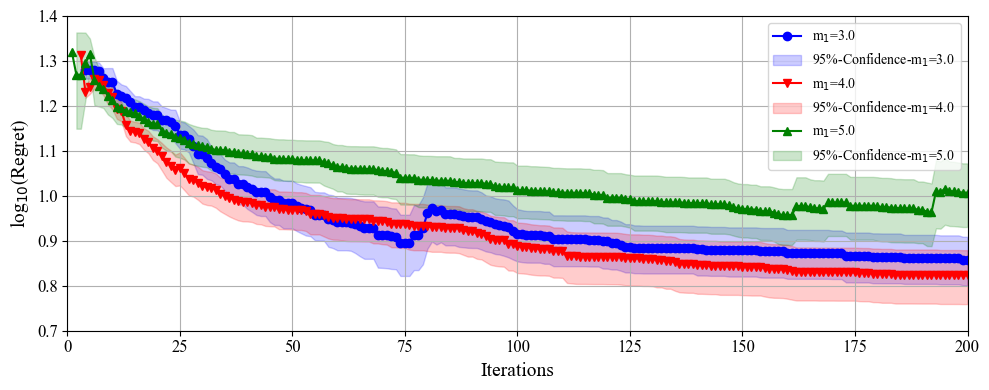

In [23]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(10,4))
iterations = range(201)

_,regret_mean,lower,upper,_ = cleaning(combined2_m1_3,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='o', color='b', label=r'm$_1$=3.0')
plt.fill_between(iterations, lower, upper, color='b', alpha=0.2, label=r'95%-Confidence-m$_1$=3.0')

_,regret_mean,lower,upper,_ = cleaning(combined2_m1_4,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='v', color='r', label=r'm$_1$=4.0')
plt.fill_between(iterations, lower, upper, color='r', alpha=0.2, label=r'95%-Confidence-m$_1$=4.0')

_,regret_mean,lower,upper,_ = cleaning(combined2_m1_5,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='^', color='g', label=r'm$_1$=5.0')
plt.fill_between(iterations, lower, upper, color='g', alpha=0.2, label=r'95%-Confidence-m$_1$=5.0')

plt.xlabel('Iterations', fontsize=14)
plt.xlim(0,200)
plt.ylim(0.7,1.4)
# plt.ylabel(r"$\log_{10}(\mathrm{Regret})$", fontsize=14)
plt.ylabel(r"log$_{10}$(Regret)", fontsize=14)
plt.legend(ncol=1)
plt.grid()
plt.tight_layout()
plt.savefig(DIR/'Hypers_m1_Case3T.png',dpi=300)
plt.show()

In [28]:
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in m2_15.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_m2_15 = df
            combined2_m2_15 = df2
            temp=1
        else:
            combined_m2_15 = pd.concat([combined_m2_15, df], axis=0, ignore_index=True)
            combined2_m2_15 = pd.concat([combined2_m2_15, df2], axis=0, ignore_index=True)
print(len(combined2_m2_15.index.to_list()))
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in m2_25.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_m2_25 = df
            combined2_m2_25 = df2
            temp=1
        else:
            combined_m2_25 = pd.concat([combined_m2_25, df], axis=0, ignore_index=True)
            combined2_m2_25 = pd.concat([combined2_m2_25, df2], axis=0, ignore_index=True)
print(len(combined2_m2_25.index.to_list()))
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in m2_20.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_m2_20 = df
            combined2_m2_20 = df2
            temp=1
        else:
            combined_m2_20 = pd.concat([combined_m2_20, df], axis=0, ignore_index=True)
            combined2_m2_20 = pd.concat([combined2_m2_20, df2], axis=0, ignore_index=True)
print(len(combined2_m2_20.index.to_list()))

45
40
65


In [180]:
combined_m2_15.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,-3.352540,2.220116,-1.278370,0.204034,1.347228,-1.516781,0.686654,0.433448,1.349192,0.884958
std,4.156017,2.842734,2.849507,2.792186,2.268703,3.160238,0.955016,1.063541,1.149974,0.451068
min,-15.661948,-1.997153,-5.997674,-4.997654,-2.995969,-7.158840,-0.940989,-0.999079,-0.132844,0.034597
25%,-5.261116,0.527471,-2.020692,-0.032079,-0.504062,-4.053806,-0.025083,-0.525237,0.319668,0.634554
50%,-3.510694,1.998326,-0.873222,0.193313,1.085473,-0.504631,0.596661,0.567422,1.019555,1.062269
75%,0.050623,3.509262,0.434473,2.031329,2.063108,1.035380,1.647782,1.117522,2.460385,1.167031
max,3.172691,8.982476,6.988867,3.998983,11.043189,2.998420,1.958341,2.967622,2.984432,1.494303


In [181]:
combined_m2_20.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,-3.058710,2.119270,-1.124000,0.147469,1.388111,-1.474967,0.715626,0.282007,1.365895,0.752915
std,3.974478,2.688530,2.936652,2.778766,2.207331,3.142755,0.963784,0.979013,1.091198,0.479869
min,-14.067417,-2.005967,-6.038439,-6.955465,-2.071422,-7.090701,-0.943539,-0.999755,-0.137856,0.002227
25%,-5.228289,0.087708,-2.050875,-0.910440,-0.028268,-4.096342,-0.093991,-0.647627,0.598586,0.284303
50%,-4.130741,2.001130,-0.028218,0.288730,1.174260,-0.092603,0.868871,0.239638,1.022393,0.708517
75%,0.268753,4.041458,0.058722,1.962233,2.036618,1.022937,1.633015,1.056199,2.447668,1.117093
max,3.509674,8.996420,6.103315,4.005395,10.940252,4.057458,1.958794,2.588788,2.993008,1.487626


In [182]:
combined_m2_25.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-3.375923,2.467752,-1.303741,0.254876,1.491486,-1.784961,0.682172,0.538933,1.339422,0.860171
std,4.899554,2.878164,3.108608,2.812740,2.204721,2.976729,1.003177,1.053863,1.171726,0.466149
min,-17.913743,-1.953784,-5.991725,-6.863121,-1.899143,-7.115148,-0.944355,-0.984219,-0.134219,0.019048
25%,-6.661037,0.695742,-2.764685,-0.941082,-0.017259,-4.204658,-0.249084,-0.352244,0.013974,0.548380
50%,-3.728934,1.999155,-0.954339,0.412339,1.995173,-1.422080,0.724808,0.658278,1.015495,0.890219
75%,0.532045,4.472077,0.276477,2.302394,2.095832,1.006563,1.672585,1.381027,2.569042,1.340115
max,3.818609,7.963689,6.088820,3.976003,10.754160,3.058669,1.942071,2.470758,2.994782,1.486624


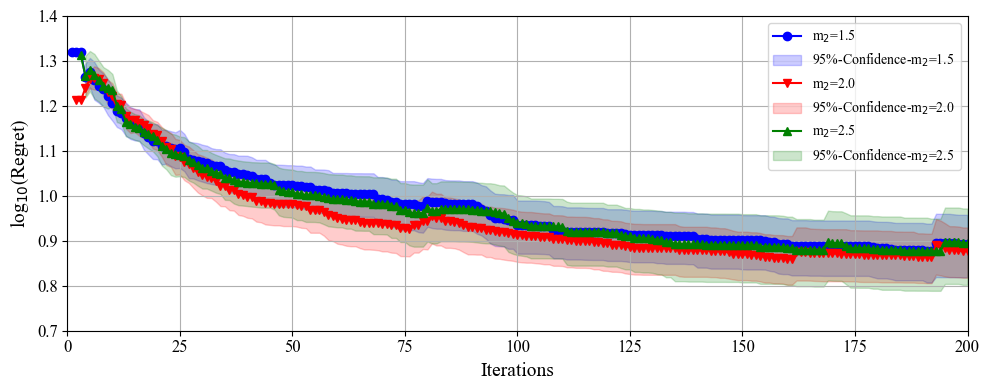

In [29]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(10,4))
iterations = range(201)

_,regret_mean,lower,upper,_ = cleaning(combined2_m2_15,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='o', color='b', label=r'm$_2$=1.5')
plt.fill_between(iterations, lower, upper, color='b', alpha=0.2, label=r'95%-Confidence-m$_2$=1.5')

_,regret_mean,lower,upper,_ = cleaning(combined2_m2_20,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='v', color='r', label=r'm$_2$=2.0')
plt.fill_between(iterations, lower, upper, color='r', alpha=0.2, label=r'95%-Confidence-m$_2$=2.0')

_,regret_mean,lower,upper,_ = cleaning(combined2_m2_25,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='^', color='g', label=r'm$_2$=2.5')
plt.fill_between(iterations, lower, upper, color='g', alpha=0.2, label=r'95%-Confidence-m$_2$=2.5')

plt.xlabel('Iterations', fontsize=14)
plt.xlim(0,200)
plt.ylim(0.7,1.4)
# plt.ylabel(r"$\log_{10}(\mathrm{Regret})$", fontsize=14)
plt.ylabel(r"log$_{10}$(Regret)", fontsize=14)
plt.legend(ncol=1)
plt.grid()
plt.tight_layout()
plt.savefig(DIR/'Hypers_m2_Case3T.png',dpi=300)
plt.show()

In [30]:
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in P1_76.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_P1_76 = df
            combined2_P1_76 = df2
            temp=1
        else:
            combined_P1_76 = pd.concat([combined_P1_76, df], axis=0, ignore_index=True)
            combined2_P1_76 = pd.concat([combined2_P1_76, df2], axis=0, ignore_index=True)
print(len(combined2_P1_76.index.to_list()))

temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in P1_78.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_P1_78 = df
            combined2_P1_78 = df2
            temp=1
        else:
            combined_P1_78 = pd.concat([combined_P1_78, df], axis=0, ignore_index=True)
            combined2_P1_78 = pd.concat([combined2_P1_78, df2], axis=0, ignore_index=True)
print(len(combined2_P1_78.index.to_list()))
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in P1_80.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_P1_80 = df
            combined2_P1_80 = df2
            temp=1
        else:
            combined_P1_80 = pd.concat([combined_P1_80, df], axis=0, ignore_index=True)
            combined2_P1_80 = pd.concat([combined2_P1_80, df2], axis=0, ignore_index=True)
print(len(combined2_P1_80.index.to_list()))

40
70
40


In [185]:
combined_P1_76.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-4.082514,2.223029,-0.959290,0.074405,1.667455,-1.722431,0.604901,0.393147,1.317276,0.882947
std,4.108496,2.882034,3.271177,3.170386,2.164843,3.214208,0.844010,1.025192,1.112846,0.440142
min,-15.661948,-2.005967,-6.038439,-6.955465,-1.046789,-6.998878,-0.918007,-0.999079,-0.137856,0.033093
25%,-6.573814,0.106179,-1.937346,-1.741578,0.615877,-4.452158,0.044178,-0.684664,0.238542,0.597100
50%,-4.518600,1.998870,-0.041855,0.834026,1.945154,-0.902423,0.660545,0.491479,1.029142,0.917051
75%,-0.623791,4.108823,0.282635,2.962581,2.994904,0.964721,1.203730,1.140393,2.550947,1.277899
max,3.172691,7.964185,6.988867,4.005395,11.043189,4.057458,1.951821,2.547360,2.927610,1.494303


In [186]:
combined_P1_78.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,-2.507672,2.099800,-1.256721,0.221911,1.035762,-1.303603,0.850908,0.441749,1.494626,0.776232
std,4.226671,2.669274,2.616307,2.608538,1.951708,2.943490,0.955387,0.970741,1.166424,0.484311
min,-14.067417,-1.997153,-5.997687,-4.952504,-2.995969,-7.158840,-0.940989,-0.999755,-0.134400,0.019048
25%,-5.176190,0.152491,-1.107000,-0.914095,-0.802421,-4.044229,-0.031280,-0.295449,0.466005,0.293915
50%,-2.426062,1.961495,-0.729013,0.122303,1.094212,-0.033372,1.085049,0.430408,1.037075,0.799136
75%,1.021492,3.026162,0.047338,1.963682,2.056948,1.037523,1.728529,1.095368,2.684469,1.147070
max,3.818609,8.982476,5.947461,3.998330,10.940252,2.998420,1.910078,2.967622,2.993008,1.487626


In [187]:
combined_P1_80.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-3.604751,2.505502,-1.408772,0.262197,1.767185,-1.873765,0.531773,0.319031,1.151241,0.832446
std,4.387121,2.876241,3.165035,2.687827,2.595717,3.229894,1.074884,1.125228,1.047748,0.473137
min,-17.913743,-1.996677,-5.998052,-4.996725,-1.899143,-7.115148,-0.944355,-0.997620,-0.134219,0.002227
25%,-5.369390,1.012362,-4.255904,-0.047549,0.034297,-4.204832,-0.584737,-0.826446,0.102670,0.471984
50%,-4.200540,2.030121,-0.790518,0.123699,1.994504,-1.484142,0.576055,0.560440,1.000454,1.040690
75%,-0.111413,4.979640,0.976784,2.036448,2.857232,1.026139,1.649775,1.110579,2.128343,1.123784
max,3.518511,8.996420,6.103315,4.001786,10.814182,3.058669,1.958794,2.588788,2.994782,1.482924


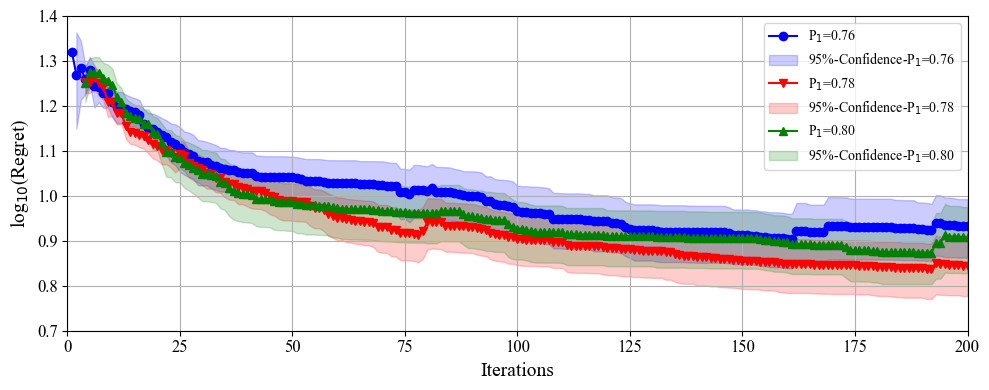

In [31]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(10,4))
iterations = range(201)

_,regret_mean,lower,upper,_ = cleaning(combined2_P1_76,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='o', color='b', label=r'P$_1$=0.76')
plt.fill_between(iterations, lower, upper, color='b', alpha=0.2, label=r'95%-Confidence-P$_1$=0.76')

_,regret_mean,lower,upper,_ = cleaning(combined2_P1_78,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='v', color='r', label=r'P$_1$=0.78')
plt.fill_between(iterations, lower, upper, color='r', alpha=0.2, label=r'95%-Confidence-P$_1$=0.78')

_,regret_mean,lower,upper,_ = cleaning(combined2_P1_80,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='^', color='g', label=r'P$_1$=0.80')
plt.fill_between(iterations, lower, upper, color='g', alpha=0.2, label=r'95%-Confidence-P$_1$=0.80')

plt.xlabel('Iterations', fontsize=14)
plt.xlim(0,200)
plt.ylim(0.7,1.4)
# plt.ylabel(r"$\log_{10}(\mathrm{Regret})$", fontsize=14)
plt.ylabel(r"log$_{10}$(Regret)", fontsize=14)
plt.legend(ncol=1)
plt.grid()
plt.tight_layout()
plt.savefig(DIR/'Hypers_P1_Case3T.png',dpi=300)
plt.show()

In [32]:
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in P2_92.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_P2_92 = df
            combined2_P2_92 = df2
            temp=1
        else:
            combined_P2_92 = pd.concat([combined_P2_92, df], axis=0, ignore_index=True)
            combined2_P2_92 = pd.concat([combined2_P2_92, df2], axis=0, ignore_index=True)
print(len(combined2_P2_92.index.to_list()))

temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in P2_95.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_P2_95 = df
            combined2_P2_95 = df2
            temp=1
        else:
            combined_P2_95 = pd.concat([combined_P2_95, df], axis=0, ignore_index=True)
            combined2_P2_95 = pd.concat([combined2_P2_95, df2], axis=0, ignore_index=True)
print(len(combined2_P2_95.index.to_list()))
temp =0
for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    if j in P2_98.index:
        df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
        df = df.iloc[0+5*m:5+5*m,:]
        df2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
        df2 = df2.iloc[0+5*m:5+5*m,:]
        if temp == 0:
            combined_P2_98 = df
            combined2_P2_98 = df2
            temp=1
        else:
            combined_P2_98 = pd.concat([combined_P2_98, df], axis=0, ignore_index=True)
            combined2_P2_98 = pd.concat([combined2_P2_98, df2], axis=0, ignore_index=True)
print(len(combined2_P2_98.index.to_list()))

45
60
45


In [190]:
combined_P2_92.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,-2.767026,1.769484,-1.176438,0.372765,1.293726,-1.328712,0.538829,0.466195,1.253031,0.765563
std,3.654234,2.578527,2.802037,2.668847,1.977881,3.049182,0.975780,0.877908,1.115332,0.423199
min,-14.067417,-1.997001,-5.997687,-4.996725,-2.071422,-6.996319,-0.943539,-0.999755,-0.137856,0.028968
25%,-5.109436,-0.927286,-2.050875,-0.910440,0.083683,-3.956195,-0.335199,-0.258517,0.137523,0.364470
50%,-3.452706,1.948572,-0.012570,0.994395,1.120516,-0.504631,0.613280,0.609111,1.017834,0.931079
75%,0.304599,4.029718,0.986054,2.000464,2.015034,1.015622,1.525176,1.135567,2.405678,1.104587
max,2.525269,6.999489,5.947461,4.005395,10.940252,4.057458,1.958794,2.267756,2.993008,1.423902


In [191]:
combined_P2_95.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,-3.529447,2.456937,-1.187878,0.175070,1.571405,-1.663581,0.749170,0.331250,1.416975,0.854610
std,4.685700,2.794535,3.034736,2.638975,2.719688,3.117197,0.955218,1.136980,1.126304,0.482666
min,-17.913743,-1.996677,-5.998052,-4.997654,-2.995969,-7.115148,-0.944355,-0.999079,-0.124989,0.002227
25%,-6.428472,1.025129,-2.020692,-0.090539,-0.073924,-4.158172,-0.001852,-0.742688,0.435628,0.545792
50%,-3.866458,2.010324,-0.906453,0.185535,1.174260,-0.875242,0.877042,0.051400,1.019117,0.897272
75%,-0.180307,4.026068,0.027692,2.009920,2.069456,0.984303,1.715237,1.069084,2.575905,1.306530
max,3.818609,8.996420,6.988867,4.001786,11.043189,3.058669,1.942071,2.967622,2.994782,1.494303


In [192]:
combined_P2_98.describe()

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,-3.301336,2.439580,-1.298978,0.032965,1.292884,-1.694309,0.792735,0.409170,1.372440,0.830163
std,4.313032,2.925967,3.014761,3.089899,1.629334,3.137268,0.970891,1.017509,1.144174,0.498722
min,-14.219571,-2.005967,-6.038439,-6.955465,-1.045773,-7.158840,-0.940989,-0.998638,-0.113925,0.019048
25%,-6.674477,0.715371,-2.419403,-1.190224,-0.265308,-4.263296,0.060728,-0.665876,0.010483,0.411129
50%,-4.086850,2.002624,-0.806845,0.098406,1.935551,-0.479561,1.149598,0.693078,1.036488,0.782155
75%,0.677298,4.479114,0.037626,2.286439,2.293309,1.025355,1.649965,1.202839,2.569042,1.356571
max,3.818609,8.982476,6.010753,4.001786,4.025360,3.002014,1.857084,2.312492,2.992082,1.486624


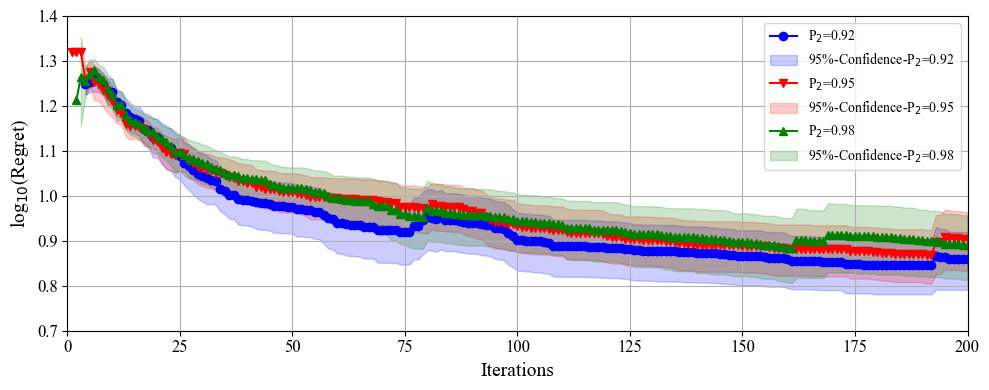

In [33]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(10,4))
iterations = range(201)

_,regret_mean,lower,upper,_ = cleaning(combined2_P2_92,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='o', color='b', label=r'P$_2$=0.92')
plt.fill_between(iterations, lower, upper, color='b', alpha=0.2, label=r'95%-Confidence-P$_2$=0.92')

_,regret_mean,lower,upper,_ = cleaning(combined2_P2_95,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='v', color='r', label=r'P$_2$=0.95')
plt.fill_between(iterations, lower, upper, color='r', alpha=0.2, label=r'95%-Confidence-P$_2$=0.95')

_,regret_mean,lower,upper,_ = cleaning(combined2_P2_98,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_mean, marker='^', color='g', label=r'P$_2$=0.98')
plt.fill_between(iterations, lower, upper, color='g', alpha=0.2, label=r'95%-Confidence-P$_2$=0.98')

plt.xlabel('Iterations', fontsize=14)
plt.xlim(0,200)
plt.ylim(0.7,1.4)
# plt.ylabel(r"$\log_{10}(\mathrm{Regret})$", fontsize=14)
plt.ylabel(r"log$_{10}$(Regret)", fontsize=14)
plt.legend(ncol=1)
plt.grid()
plt.tight_layout()
plt.savefig(DIR/'Hypers_P2_Case3T.png',dpi=300)
plt.show()

In [194]:
len(df_no_duplicates.index.tolist())

30

In [195]:
df_bench = pd.read_csv(DIR.parent/'Algorithms'/f'{sol}_Results_{case_name}_100.csv')
df_bench = df_bench.iloc[0:5,0:300]
df_bench.describe() ## included in LHS section 

,obj,x_1,x_2,x_3,x_4,x_5,con_1,con_2,con_3,con_4
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-5.783272,2.815949,-0.406928,-0.227291,3.586650,-2.722821,0.803444,0.262812,0.600679,0.805360
std,5.570610,3.256838,4.023383,2.569414,4.718215,3.998475,1.093883,1.041637,0.650743,0.656286
min,-14.067417,-0.983482,-5.003674,-3.998680,-2.071442,-6.903627,-0.497806,-0.915078,-0.212648,0.029969
25%,-6.678419,2.052784,-2.050129,-0.911260,2.006591,-4.996054,-0.050708,-0.834577,0.018766,0.291305
50%,-6.581341,2.061518,-0.981564,-0.193353,3.052756,-4.801439,0.785747,0.935518,0.951727,0.785650
75%,-2.258773,2.954014,0.053264,0.998350,4.005092,1.004662,1.858375,0.987646,1.010206,1.456132
max,0.669591,7.994910,5.947461,2.968490,10.940252,2.082354,1.921611,1.140553,1.235342,1.463745


In [196]:
df_bench = pd.read_csv(DIR.parent/'Algorithms'/f'{sol}_Results2_{case_name}_100.csv')
df_bench = df_bench.iloc[0:5,0:300] 
a,regret_mean_bench,lower_bench,upper_bench,non_count = cleaning(df_bench,n_init=100,iter=200,opt=4.48)

In [36]:
lhsdata = pd.read_csv(DIR/'LHS_Case3T.csv')

In [198]:
mean_list = []
larger = 0

for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    df =pd.read_csv(DIR/f'{sol}_Hyper_Results_{case_name}_{runs_number}_{i}.csv')
    df = df.iloc[0+5*m:5+5*m,:]
    mean_list.append(-df['obj'].mean())
    if -df['obj'].mean() > 5.783272:
        larger =  larger+1
    print(lhsdata.loc[j,:].tolist(),':  ',-df['obj'].mean(),-df['obj'].min(),-df['obj'].max(),df['obj'].count())
print(min(mean_list),max(mean_list))
print(larger)

[4.0, 2.0, 0.78, 0.98] :   0.969787787906372 6.660671448692085 -3.509674034587746 5
[4.0, 2.0, 0.78, 0.95] :   1.1230250362422656 6.660671448692085 -3.4417461053641705 5
[3.0, 1.5, 0.78, 0.92] :   2.8616200527241005 6.902473252538716 -0.8837421210337655 5
[3.0, 2.0, 0.76, 0.95] :   3.163903370999383 6.811609061644887 0.1370405733696427 5
[4.0, 2.5, 0.8, 0.95] :   2.37370680142626 6.679444774318608 -3.51851075401014 5
[4.0, 2.5, 0.76, 0.98] :   4.609961879471945 7.353560990190807 -1.2143838625255472 5
[5.0, 1.5, 0.76, 0.95] :   5.873216809851547 15.661948264176631 0.4665822307438643 5
[3.0, 2.0, 0.76, 0.92] :   2.868802625991029 6.286317606762584 -1.9943378410649788 5
[5.0, 1.5, 0.78, 0.95] :   3.7867100926411217 11.191757708979516 -2.508383073546834 4
[4.0, 1.5, 0.8, 0.92] :   2.281586789809533 5.345816623625257 -2.525268708852213 5
[5.0, 2.0, 0.76, 0.98] :   4.767918315106491 8.251502488820407 0.832812350415939 5
[4.0, 2.5, 0.78, 0.98] :   1.2302143396328913 8.641426668108398 -3.81860

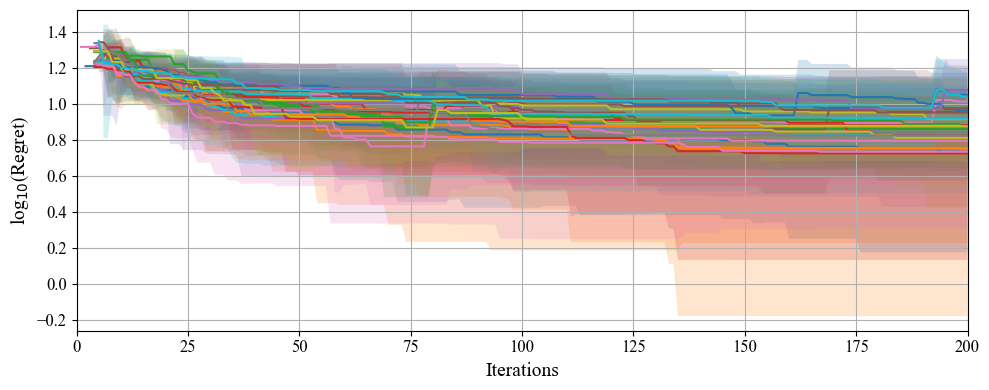

In [34]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(10,4))
iterations = range(201)

for j in df_no_duplicates.index:
    i = j//5
    m = j%5
    df_Res2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
    df_Res2 = df_Res2.iloc[0+5*m:5+5*m,:]
    _,regret_mean,lower,upper,_ = cleaning(df_Res2,n_init=100,iter=200,opt=4.48)
    plt.plot(iterations, regret_mean, label=i)
    plt.fill_between(iterations, lower, upper, alpha=0.2, label=f'95%-Confidence-{i}')

plt.xlabel('Iterations', fontsize=14)
plt.xlim(0,200)
# plt.ylim(0.7,1.4)
# plt.ylabel(r"$\log_{10}(\mathrm{Regret})$", fontsize=14)
plt.ylabel(r"log$_{10}$(Regret)", fontsize=14)
# plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
plt.savefig(DIR/'Hypers_all_Case3T.png',dpi=300)
plt.show()

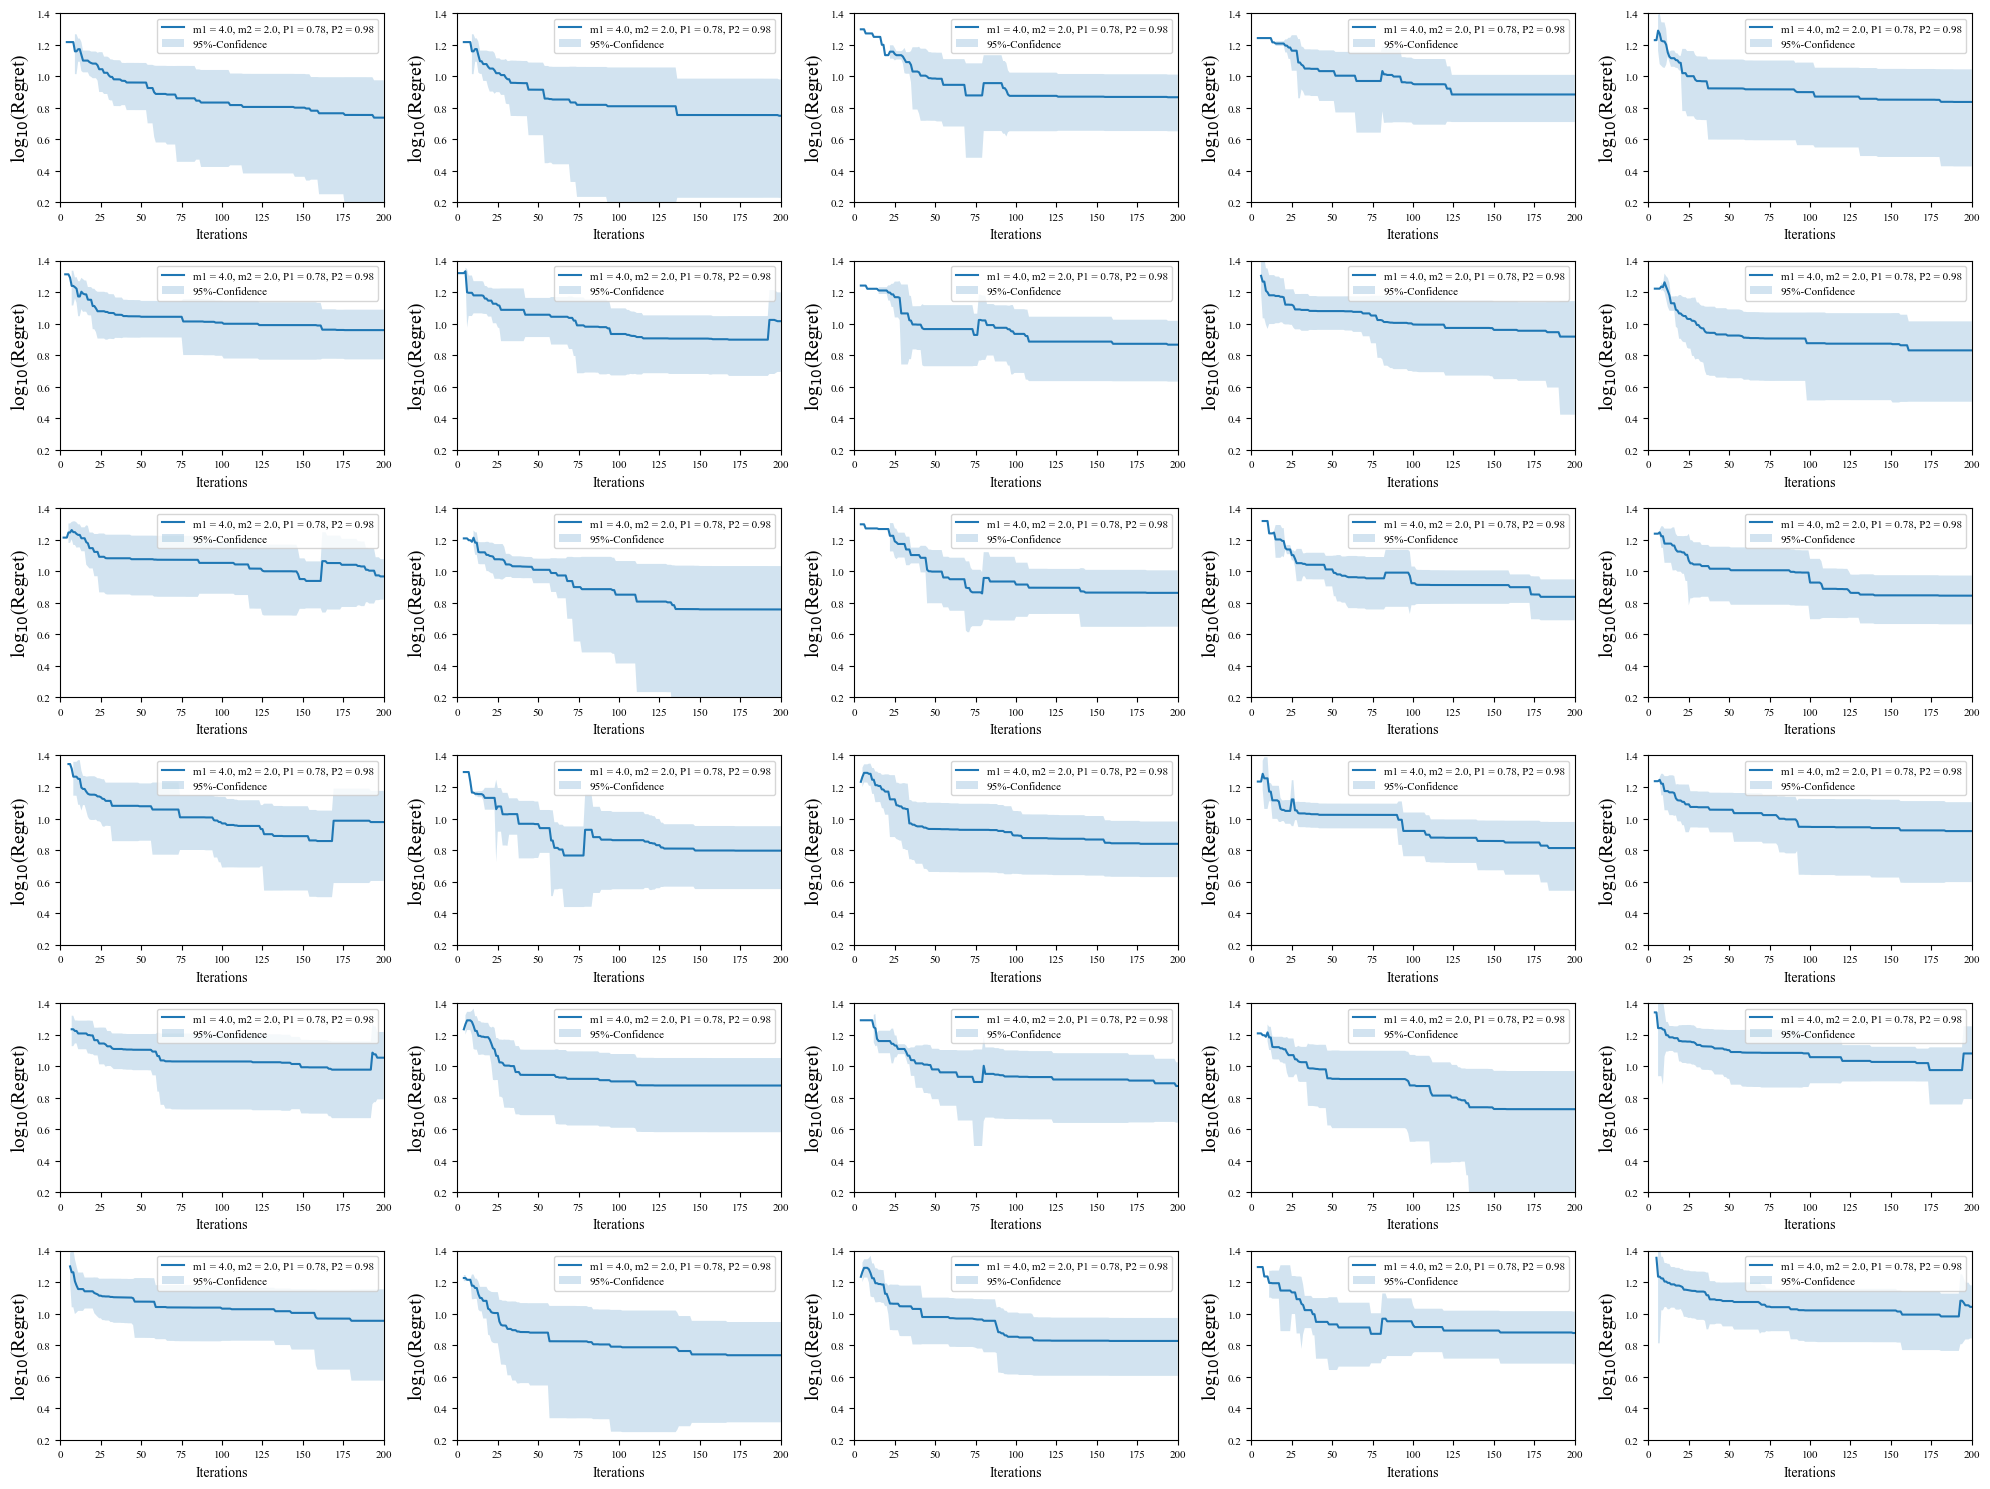

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, axes = plt.subplots(6, 5, figsize=(20, 15))  # 创建 8x5 的子图布局
iterations = range(201)

# for j in lhsdata.index:    
k =0
for j in df_no_duplicates.index:
    i = j // 5
    m = j % 5
    df_Res2 = pd.read_csv(DIR / f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
    df_Res2 = df_Res2.iloc[0 + 5 * m : 5 + 5 * m, :]
    _, regret_mean, lower, upper,_ = cleaning(df_Res2, n_init=100, iter=200, opt=4.48)
    
    ax = axes[k // 5, k % 5]
    k=k+1
    ax.plot(iterations, regret_mean, label=f'm1 = {lhsdata.loc[0][0]}, m2 = {lhsdata.loc[0][1]}, P1 = {lhsdata.loc[0][2]}, P2 = {lhsdata.loc[0][3]}')
    ax.fill_between(iterations, lower, upper, alpha=0.2, label=f'95%-Confidence')
    
    # ax.set_title(f'm1 = {lhsdata.loc[0][0]}, m2 = {lhsdata.loc[0][1]}, P1 = {lhsdata.loc[0][2]}, P2 = {lhsdata.loc[0][3]}', fontsize=10)
    ax.set_xlim(0, 200)
    ax.set_xlabel('Iterations', fontsize=10)
    # ax.set_ylabel(r"$\log_{10}(\mathrm{Regret})$", fontsize=10)
    ax.set_ylabel(r"log$_{10}$(Regret)", fontsize=14)
    ax.tick_params(axis='both', labelsize=8)
    ax.legend(fontsize=8, loc='upper right')
    # ax.grid()
    ax.set_ylim(0.2,1.4)
plt.tight_layout()
plt.savefig(DIR/'Hypers_all2_Case3T.png',dpi=300)
plt.show()


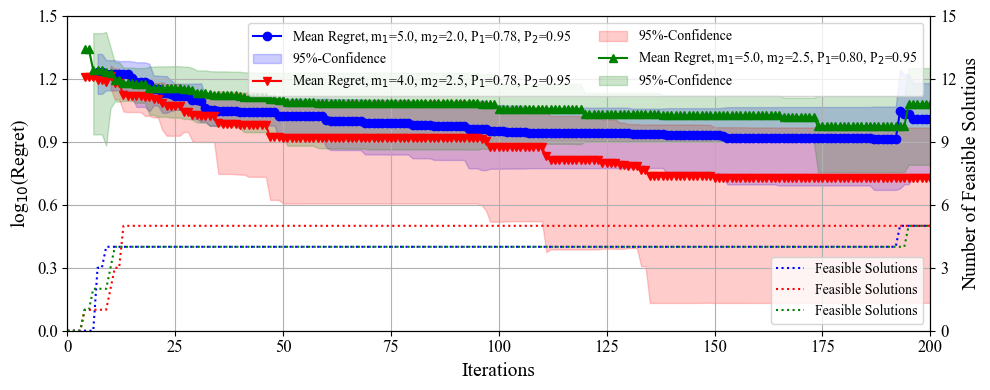

In [22]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 16 29 31
# 3 0, 5 3, 6 0
plt.figure(figsize=(10,4))

iterations = range(201)
i = 3
m = 0
df_Res2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
df_Res2 = df_Res2.iloc[0+5*m:5+5*m,:]
_,regret_meanS1,lowerS1,upperS1,S1 = cleaning(df_Res2,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_meanS1, marker='o', color='b', label= r'Mean Regret, m$_1$=5.0, m$_2$=2.0, P$_1$=0.78, P$_2$=0.95')
plt.fill_between(iterations, lowerS1, upperS1, color='b', alpha=0.2, label=f'95%-Confidence')
i = 5
m = 3
df_Res2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
df_Res2 = df_Res2.iloc[0+5*m:5+5*m,:]
_,regret_meanS2,lowerS2,upperS2,S2 = cleaning(df_Res2,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_meanS2, marker='v', color='r', label=r'Mean Regret, m$_1$=4.0, m$_2$=2.5, P$_1$=0.78, P$_2$=0.95')
plt.fill_between(iterations, lowerS2, upperS2, color='r', alpha=0.2, label=f'95%-Confidence')
i = 6
m = 0
df_Res2 =pd.read_csv(DIR/f'{sol}_Hyper_Results2_{case_name}_{runs_number}_{i}.csv')
df_Res2 = df_Res2.iloc[0+5*m:5+5*m,:]
_,regret_meanS3,lowerS3,upperS3,S3 = cleaning(df_Res2,n_init=100,iter=200,opt=4.48)
plt.plot(iterations, regret_meanS3, marker='^', color='g', label=r'Mean Regret, m$_1$=5.0, m$_2$=2.5, P$_1$=0.80, P$_2$=0.95')
plt.fill_between(iterations, lowerS3, upperS3, color='g', alpha=0.2, label=f'95%-Confidence')

plt.xlabel('Iterations', fontsize=14)
plt.xlim(0,200)
plt.ylim(0,1.5)
plt.yticks([0, 0.3, 0.6, 0.9, 1.2,1.5])
# plt.ylabel(r"$\log_{10}(\mathrm{Regret})$", fontsize=14)
plt.ylabel(r"log$_{10}$(Regret)", fontsize=14)
plt.legend(loc='upper right',ncol=2)
plt.grid()
ax2 = plt.gca().twinx()
ax2.plot(iterations, S1, 'b:', label='Feasible Solutions')
ax2.plot(iterations, S2, 'r:', label='Feasible Solutions')
ax2.plot(iterations, S3, 'g:', label='Feasible Solutions')
ax2.set_ylabel('Number of Feasible Solutions', fontsize=14)
lines_1, labels_1 = plt.gca().get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(loc='lower right',ncol=1)
plt.ylim(0,15)
plt.yticks([0, 3, 6, 9, 12,15])

plt.tight_layout()
plt.savefig(DIR/'Hypers_Case3T.png',dpi=300)
plt.show()


In [209]:
data_dict = {
    'Mean_S1': regret_meanS1,
    'Lower_S1': lowerS1,
    'Upper_S1': upperS1,
    'S1': S1,
    'Mean_S2': regret_meanS2,
    'Lower_S2': lowerS2,
    'Upper_S2': upperS2,
    'S2': S2,
    'Mean_S3': regret_meanS3,
    'Lower_S3': lowerS3,
    'Upper_S3': upperS3,
    'S3': S3,    
}

combined_df = pd.concat(data_dict, axis=1)  
combined_df.to_csv(DIR/'Figure4.csv') 